<a href="https://colab.research.google.com/github/mohdammar128/DeepLearning-/blob/main/cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About Datasets and library

1.   Here I have used cifar datasets having 10 classes
2.   I am using pytorch library for this




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
#for preparing data and transformation as well as normalization
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

#-----------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np


## **Data preparation and Normalization**



**1. transforms.ToTensor():** This converts the input image (PIL Image or numpy array) to a PyTorch tensor. It also scales the pixel values from [0, 255] to [0, 1].

**2.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)):** This normalizes the tensor image with mean (0.5, 0.5, 0.5) and standard deviation (0.5, 0.5, 0.5) for each of the three color channels. This helps in improving the training process of the model.

**3. The transforms.Compose** function chains these two transformations together. So, first the image is converted to a tensor, and then it is normalized.



In [ ]:
#converting dataset into tensor normalized form

transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [ ]:
#importing cifr datasets
train_data=datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
test_data=datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)


100%|██████████| 170498071/170498071 [00:10<00:00, 16012453.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



### Batch size
A batch size of 20 means that during each training iteration, the model will process 20 samples at a time to compute the loss and update its parameters.

This means:

20 images will be passed through the model simultaneously in each forward pass.
The gradients will be calculated based on the average loss over these 20 images.
The model's weights will be updated once per batch, based on these calculated gradients.

---
### np.random.shuffle(indices)
np.random.shuffle(indices): This function shuffles the elements of the indices array randomly. This is often done before splitting a dataset to ensure that the training and validation/test sets have a similar distribution of samples.



In [ ]:
batch_size=20
num_workers=0 #it is used for parallel processing (if you have multiple core )
num_train=len(train_data)
print(f"num_train: {num_train}")
indices=list(range(num_train))
print(f"indices: {indices[49998:50000]}")
np.random.shuffle(indices)
print(f"shuffled Indices: {indices[:5]}")
split=int(np.floor(0.2*num_train)) #20 percent of total image
train_idx,valid_idx=indices[split:],indices[:split]


num_train: 50000
indices: [49998, 49999]
shuffled Indices: [12153, 31370, 11662, 48024, 27547]


In [ ]:
train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

#prepare dataloader (combiner dataset and sample)
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)

classes=[ 'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
print(f"type of train loader {type(train_loader)}")
print(f"type of valid loader {type(valid_loader)}")
print(f"type of test loader {type(test_loader)}")

type of train loader <class 'torch.utils.data.dataloader.DataLoader'>
type of valid loader <class 'torch.utils.data.dataloader.DataLoader'>
type of test loader <class 'torch.utils.data.dataloader.DataLoader'>


## **Visualizing train images**

In [ ]:
#obtain one batch of training data
dataiter=iter(train_loader)
images,labels=next(dataiter)
print(f"shape of images: {images.shape}")
print(f"shape of labels: {labels.shape}")
images=images.numpy()     #(batchsize,channel,height,widht)
print(f"shape of images: {images.shape}")
def helper(img):
  img=img*0.5+0.5
  npimg=img.numpy()
  print(f"shape of image: {npimg.shape}")
  plt.imshow(np.transpose(npimg,(1,2,0))) #(channel,height,width)
  plt.show()


shape of images: torch.Size([20, 3, 32, 32])
shape of labels: torch.Size([20])
shape of images: (20, 3, 32, 32)


Suppose you have an image tensor with shape (3, 28, 28), representing an RGB image with 3 channels and dimensions 28x28. When you use np.transpose(npimg, (1, 2, 0)), it will rearrange the dimensions to (28, 28, 3), which is compatible with plt.imshow().

In [ ]:
def imgshow(img):
  ## Unnormalize
  ##image = image * std + mean
  img=img*0.5+0.5

  plt.imshow(np.transpose(img,(1,2,0))) #convert from tensor image , (1,2,0)==(channel,height,width)


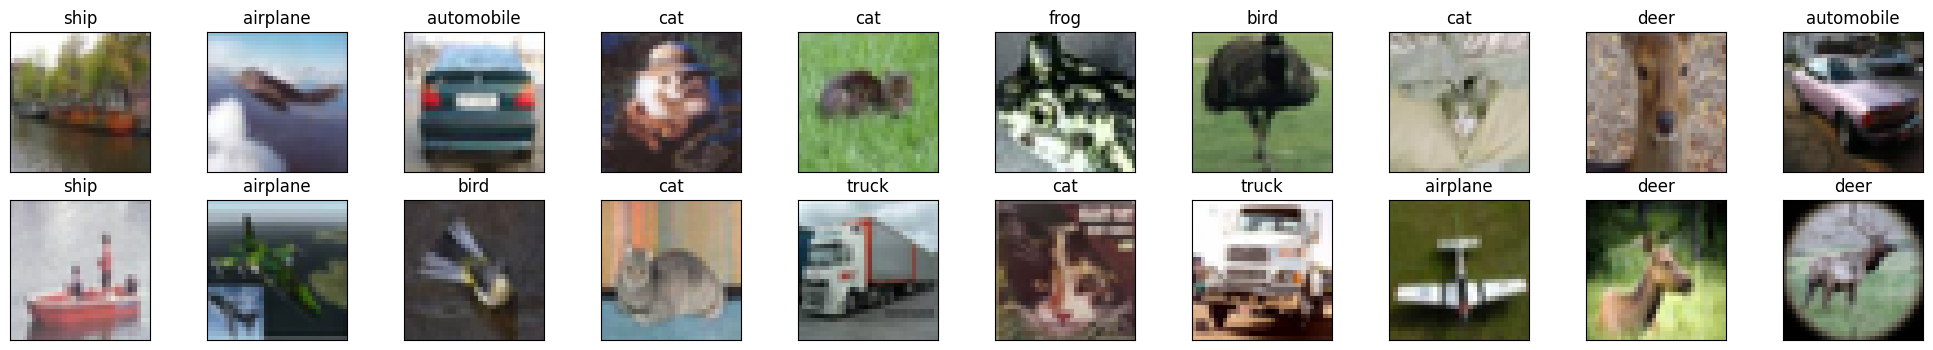

In [ ]:
fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
  imgshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [ ]:
iterator=iter(train_loader)
images,labels=next(iterator)
print(f"shape of images: {images.shape}")
print(f"shape of labels: {labels.shape}")

shape of images: torch.Size([20, 3, 32, 32])
shape of labels: torch.Size([20])


In [ ]:
images[0].shape

torch.Size([3, 32, 32])

In [ ]:
def calculte_size_conv(Input_height,kernel_size,stride=1,padding=1):
  return ((Input_height-kernel_size+2*padding)/stride)+1

def calculte_size_pool(Input_height,kernel_size,stride=2):
  return ((Input_height-kernel_size)/stride)+1


In [ ]:
height=32
wight=32
res=calculte_size_conv(height,3)
print(res)
res=calculte_size_pool(res,2)
print(res)
res=calculte_size_conv(res,3)
print(res)
res=calculte_size_pool(res,2)
print(res)

32.0
16.0
16.0
8.0


In [ ]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN,self).__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
    self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
    self.maxpool=nn.MaxPool2d(kernel_size=2,stride=2)
    #linear layer (64*4*4,500)
    self.fc1=nn.Linear(64*4*4,500) # first hidden layer
    self.fc2=nn.Linear(500,10) # second hidden layer
    self.dropout=nn.Dropout(0.25)

  def forward(self,x):
    x=self.maxpool(F.relu(self.conv1(x))) #here relu function is applid to make negative value 0 in other term to add non-linarity in the model
    x=self.maxpool(F.relu(self.conv2(x)))
    x=self.maxpool(F.relu(self.conv3(x)))

    x=x.view(-1,64*4*4)
    x=self.dropout(x)
    x=F.relu(self.fc1(x))
    x=self.dropout(x)
    x=self.fc2(x)
    return x




## Selecting Single Image

In [ ]:
model=SimpleCNN()
print(f"model: {model}")

model: SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
cirterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01)

In [ ]:

model.load_state_dict(torch.load('model_cifar.pt'))

<ipython-input-22-30c1fa6c7551>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_cifar.pt'))


FileNotFoundError: [Errno 2] No such file or directory: 'model_cifar.pt'

In [ ]:


n_epochs = 10
valid_loss_min = np.Inf  # Track minimum validation loss
## Keeping track of training and validation loss
for epoch in range(1, n_epochs + 1):  # Corrected range
    train_loss = 0.0
    valid_loss = 0.0

    ## Train the model
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        # Calculating the output for each batch
        output = model(data)
        # Calculating the loss
        loss = cirterion(output, target)  # Fixed typo 'cirterion' -> 'criterion'
        loss.backward()
        optimizer.step()  # Update the parameters

        # Accumulate training loss
        train_loss += loss.item() * data.size(0)

    ## Validate the model
    model.eval()
    with torch.no_grad():  # No need to compute gradients during validation
        for data, target in valid_loader:
            output = model(data)
            loss =cirterion(output, target)
            valid_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    print(f"Epoch: {epoch}\tTraining Loss: {train_loss:.6f}\tValidation Loss: {valid_loss:.6f}")

    # Save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
            valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss


Epoch: 1	Training Loss: 2.102839	Validation Loss: 1.934238
Validation loss decreased (inf --> 1.934238). Saving model ...


KeyboardInterrupt: 

In [ ]:
from PIL import Image
import requests
from io import BytesIO

In [ ]:
transform_pred=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
 ])

In [ ]:
def predict_image(url):
    # Step 1: Fetch the image from the URL
    response = requests.get(url)
    if response.status_code != 200:
        print("Error fetching image")
        return None

    # Step 2: Open the image using BytesIO
    img = Image.open(BytesIO(response.content))
    print(f"Image size: {img.size}")  # Print size of the image

    # Step 3: Transform the image
    img_transformed = transform_pred(img)  # Make sure transform_pred is defined
    img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension
    print(f"Shape of image: {img_transformed.shape}")

    # Step 4: Make prediction
    with torch.no_grad():  # Disable gradient calculations
        output = model(img_transformed)  # Pass the image through the model

        # Step 5: Apply softmax to get probabilities
        probabilities = F.softmax(output, dim=1)
        print(f"Probabilities: {probabilities}")

        # Step 6: Get the predicted class
        predicted_class = torch.argmax(probabilities, dim=1)
        print(f"Predicted class index: {predicted_class.item()}")

    # Step 7: Return the predicted class label
    return classes[predicted_class.item()]  # Make sure 'classes' is defined

# Example usage
url = "https://img.freepik.com/free-vector/adorable-wideeyed-kitten-illustration_1308-164226.jpg"
predicted_label = predict_image(url)
print(f"Predicted label: {predicted_label}")
